In [78]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss, GroupNormalizer
from pytorch_lightning.loggers import TensorBoardLogger

## Loading Data

This snippet will load the CSV and split it with a given ratio. CSV should have a first title
row "timestamp, value". This is designed to work on synthetics


In [79]:
prediction_length = 60 * 2
input_df = pd.read_csv('data/synthetic_daily_sin_1.csv')


# Prep data
input_df['minutes_since_start'] = range(0, len(input_df))
input_df['group'] = ['m1'] * len(input_df)
input_df['timestamp'] = pd.to_datetime(input_df['timestamp'])
print(input_df.head())

input_df.tail(prediction_length)

   Unnamed: 0           timestamp      value  minutes_since_start group
0           0 2023-01-01 00:00:00  27.224691                    0    m1
1           1 2023-01-01 00:01:00  11.310333                    1    m1
2           2 2023-01-01 00:02:00  24.404527                    2    m1
3           3 2023-01-01 00:03:00  12.728395                    3    m1
4           4 2023-01-01 00:04:00   6.555822                    4    m1


,Unnamed: 0,timestamp,value,minutes_since_start,group
18601,18601,2023-01-13 22:01:00,484.619829,18601,m1
18602,18602,2023-01-13 22:02:00,481.976135,18602,m1
18603,18603,2023-01-13 22:03:00,504.906423,18603,m1
18604,18604,2023-01-13 22:04:00,483.724190,18604,m1
18605,18605,2023-01-13 22:05:00,500.599849,18605,m1
...,...,...,...,...,...
18716,18716,2023-01-13 23:56:00,558.949086,18716,m1
18717,18717,2023-01-13 23:57:00,552.262681,18717,m1
18718,18718,2023-01-13 23:58:00,547.339637,18718,m1
18719,18719,2023-01-13 23:59:00,541.390579,18719,m1


In [80]:
 # Let's predict 15th day
cutoff_time_index = max(input_df['minutes_since_start']) - prediction_length

# Let's look at datset
training_ds = TimeSeriesDataSet(
    data=input_df[lambda x: x.minutes_since_start <= cutoff_time_index],
    time_idx='minutes_since_start',
    target='value',
    group_ids=['group'],
    min_encoder_length=1,
    max_encoder_length=60,
    min_prediction_length=1,
    max_prediction_length=prediction_length,

    static_categoricals=["group"],
    static_reals=[],
    time_varying_known_categoricals=[],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["minutes_since_start"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "value",
    ],
    target_normalizer=GroupNormalizer(
        groups=["group"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation_ds = TimeSeriesDataSet.from_dataset(training_ds, input_df, predict=True, stop_randomization=True)



In [81]:
batch_size = 64
num_workers = 0

train_dataloader = training_ds.to_dataloader(train=True, batch_size=batch_size, num_workers=num_workers)
val_dataloader = validation_ds.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=num_workers)

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")  # log to tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    accelerator='gpu',
    devices=[0],
    enable_model_summary=True,
    gradient_clip_val=0,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [82]:
optimal_learning_rate = 0.008
# create the model
tft = TemporalFusionTransformer.from_dataset(
    training_ds,
    learning_rate=optimal_learning_rate if optimal_learning_rate is not None else 0.03,
    hidden_size=16,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=2,
    reduce_on_plateau_patience=4,
    optimizer='adam'
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")



# find optimal learning rate (set limit_train_batches to 1.0 and log_interval = -1)
if optimal_learning_rate is None:
    res = trainer.tuner.lr_find(
        tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

    print(f"suggested learning rate, update optimal_learning_rate with it to avoid reruns: {res.suggestion()}")

Number of parameters in network: 23.7k


C:\Users\mains\AppData\Roaming\JetBrains\DataSpell2022.3\projects\workspace\venv\lib\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\mains\AppData\Roaming\JetBrains\DataSpell2022.3\projects\workspace\venv\lib\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [83]:
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 192   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.8 K 
5  

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\mains\AppData\Roaming\JetBrains\DataSpell2022.3\projects\workspace\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\mains\AppData\Roaming\JetBrains\DataSpell2022.3\projects\workspace\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

C:\Users\mains\AppData\Roaming\JetBrains\DataSpell2022.3\projects\workspace\venv\lib\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\mains\AppData\Roaming\JetBrains\DataSpell2022.3\projects\workspace\venv\lib\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


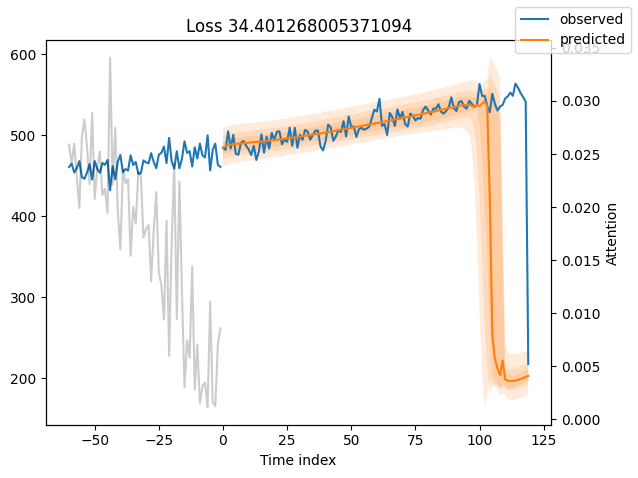

In [86]:
# https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html#Evaluate-performance

best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

raw_predictions, x = best_tft.predict(val_dataloader, mode='raw', return_x=True)
best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);